In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import itertools

# Network libraries
import networkx as nx
from fa2 import ForceAtlas2 as FA2
import community

# NLP libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

# Display libraries
from IPython.display import display
from IPython.core.display import display as disp, HTML
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
from IPython.display import Image
import imageio

from plotly import __version__
import plotly.io as pio
import plotly.express as px
import plotly.figure_factory as ff
import chart_studio.plotly as py
import plotly.offline
import plotly.graph_objs as go
sns.set()

pio.renderers.default = 'notebook'

business_df = pd.read_csv('./data/las_vegas_all_business.csv')
review_df = pd.read_csv('./data/las_vegas_all_reviews.csv')
keywords = pd.read_csv('./data/las_vegas_business_keywords.csv')

import warnings
warnings.filterwarnings('ignore')
# Filter business_id according to the category
filter_business_id = business_df[business_df.categories.str.contains(r"(Hotels, )|(, Hotels$)", regex = True)==True].business_id
# Filter businesses
business_df = business_df[business_df.business_id.isin(filter_business_id)].reset_index().drop('index', axis = 1).rename({'stars': 'stars_business'})
# Filter reviews based on business_id
review_df = review_df[review_df.business_id.isin(filter_business_id)].reset_index().drop('index', axis = 1).rename({'stars': 'stars_review'})

In [2]:
business_review_df = pd.merge(business_df, review_df, on='business_id', how='outer')
# Function to test if something is an adjective
is_adj = (lambda pos: pos[:2] == 'JJ')

# Function for tokenizing the text into a list of words
def tokenize_text(text):
    # Replace all the non-alphanumeric characters with space
    text = re.sub(r'[\W]', ' ', text)

    # Tokenize texts into lists of tokens
    words = word_tokenize(text)    
   
    stop_words = set(stopwords.words('english'))
       
    words = [word.lower() for word in words if word not in string.punctuation]    # Remove punctuation and set words to lowercase
    words = [word for word in words
                 if word not in stop_words
                 if len(word) > 1]    # Remove stopwords and letters (stopwords are lowercase, so this step should be done after word.lower())
    words = [word for (word, pos) in nltk.pos_tag(words) if is_adj(pos)]    # Keep adjectives only

    return words

def reviews(df, mode, dict_communities = None):
    
    if mode == 'community':
        # Create a dictionary for storing text of each community
        community_reviews = {}
        for comm in dict_communities.keys():
            community_text = ' '
            for business_id in dict_communities[comm]:
                business_text = ' '.join(df[df.business_id==business_id].text)
                community_text += business_text
            community_reviews[comm] = community_text
        return community_reviews
      
    if mode == 'business':
        # Within each business
        business_reviews = {}
        for business_id in df.business_id.unique():      
            # Concatenate all reviews of a specific business into one text
            business_text = ' '.join(df[df.business_id==business_id].text)
            business_reviews[business_id]  = business_text
        return business_reviews
    
# Function for computing TF (using different methods)
def tf(reviews, tf_method = 'term_frequency'):

    # Create a nested dictionary {business: {word: tf score}} or {business: {word: tf score}} for storing term-frequency
    term_frequency = {}

    for comm, review in reviews.items():
        # Create a dictionary for each either community or business to store words and counts of words
        term_frequency[comm] = {}

        # Total word amount for one business (for tf_method=='term_frequency')
        total_word_amount = len(review)
        # Tokenize the text into a list of words
        words = tokenize_text(review)
        # Count words
        for word in words:
            if word not in term_frequency[comm].keys():
                term_frequency[comm][word] = 1
            else:
                term_frequency[comm][word] += 1       

        # Compute different types of term frequency
        if tf_method == 'raw_count':
            term_frequency = term_frequency

        elif tf_method == 'term_frequency':
            term_frequency[comm] = {k : v/total_word_amount for k, v in term_frequency[comm].items()}

        elif tf_method == 'log':
            term_frequency[comm] = {k : math.log(1 + v) for k, v in term_frequency[comm].items()}

        elif tf_method == 'double_normalization':
            term_frequency[comm] = {k : (0.5 + 0.5*v/max(term_frequency[comm].values())) for k, v in term_frequency[comm].items()}        

    return term_frequency

# Function for computing IDF (using different methods)
def idf(reviews, term_frequency, idf_method='idf'):
    # Total number of documents (i.e. total number of businesses in this case, because we concatenate all the reviews of one specific business)
    N = len(reviews.keys())
    
    # Create a nested dictionary for {business: {word: idf score}} storing term-frequency
    inverse_document_frequency = {}
    
    for comm1 in term_frequency.keys():
        # Update the idf dictionary into form as {business: {word: 0}}
        inverse_document_frequency[comm1] = {k : 0 for k in term_frequency[comm1].keys()}
        
        for word in term_frequency[comm1]:
            # If a specific word occurs in another business, add 1 to the count of this word
            for comm2 in term_frequency.keys():
                if word in term_frequency[comm2].keys():
                    inverse_document_frequency[comm1][word] += 1
        
        # Compute different types of inverse document frequency based on the number of occurance of a word in all the businesses
        if idf_method == 'idf':
            inverse_document_frequency[comm1] = {k : math.log(N/v) for k, v in inverse_document_frequency[comm1].items()}
        elif idf_method == 'idf_smooth':
            inverse_document_frequency[comm1] = {k : (math.log(N/(1+v))+1) for k, v in inverse_document_frequency[comm1].items()}
    
    
    return inverse_document_frequency

# Function for computing TD-IDF score
def tf_idf(term_frequency, inverse_document_frequency):
    
    tf_idf = {}
    for comm in term_frequency:
        tf_idf[comm] = {k : v*term_frequency[comm][k] for k, v in inverse_document_frequency[comm].items()}
    
    return tf_idf

# Convert reviews of each business into one text for analysis
business_reviews = reviews(df = business_review_df, mode = 'business')
# Calculate term frequency of each business
business_term_frequency = tf(reviews = business_reviews, tf_method = 'term_frequency')
# Calculate inverse document frequency of each business
business_inverse_document_frequency  =  idf(reviews = business_reviews, term_frequency = business_term_frequency, idf_method = 'idf')
# Calculate TF-IDF score of each business
business_tf_idf = tf_idf(term_frequency = business_term_frequency,  inverse_document_frequency = business_inverse_document_frequency)


# Function for extracting top keywords with highest TF-IDF score of each business
def retrieve_top_n_keywords(n, tf_idf_score = business_tf_idf):
    
    # Create a dictionary, which will contain top n keywords for each business
    top_keywords_dict = {}
    
    # For each business, we will save its business_id and its top n keywords in a dictionary
    for business_id, term_dict in tf_idf_score.items():
        
        # Sort the terms by their TF-IDF score (descendingly), and keep the top n keywords
        top_n_keywords_list = [tf_idf_tuple[0] for tf_idf_tuple in sorted(term_dict.items(), key = (lambda x : x[1]), reverse = True)][0:n]
        top_keywords_dict[business_id] = list(top_n_keywords_list)
        
    return top_keywords_dict

# n = how many top keywords should the network check for nodes to have in common
n = 10
business_top_keywords = retrieve_top_n_keywords(n)

# Add a column containing top keywords of each business to the original dataframe
business_df['top_keywords'] = business_df['business_id'].map(business_top_keywords)

# Network analysis 

After we have determined the top 10 most relevant keywords for each business in part, these **keywords are being used to define the connection between the hotels** and the number of the common keywords determine the strengths of connections.

There are initially 438 hotels/nodes in the network, where **421** of them remains after removing the isolated nodes. We have found **10790 edges** in the network.  

In [3]:
G = nx.Graph()

# Adding nodes
G.add_nodes_from(business_top_keywords.keys())

# Assign business name as an attribute to each node/business (for plotting it later)
for node in G.nodes:
    G.nodes[node]['business_name'] = business_df.name[business_df.business_id == node].values[0]
print('Initially, the total number of nodes/businesses in the network is:', G.number_of_nodes())

Initially, the total number of nodes/businesses in the network is: 438


In [4]:
keyword_df = pd.DataFrame(business_top_keywords).melt(var_name = 'business_id', value_name = 'keywords').reset_index()

# Group keywords by 'business_id', to find the businesses sharing top keywords

grouped_keyword_df = keyword_df.groupby(['keywords', 'business_id']).count()['index']

for _, business_sub_df in grouped_keyword_df.groupby(level = 0):
    
    # This is a list of combinations of 2 businesses which have the same top keyword in common
    edges_list = list(itertools.combinations(business_sub_df.droplevel(0).index, 2))
    
    for node1, node2 in edges_list:
        
        if G.has_edge(node1, node2):
            # we added this connection before, just increase the weight by one
            G[node1][node2]['weight'] += 1
            
        else:
            # new edge, therefore initialize link with weight = 1
            G.add_edge(node1, node2, weight = 1)
            

In [5]:
# Remove the isolated nodes from the graph
G.remove_nodes_from(list(nx.isolates(G)))

# Remove nodes outside the main connected component (i.e. outside the GCC)
for component in list(nx.connected_components(G.to_undirected())):
    if (len(component) < 5):
        for node in component:
            G.remove_node(node)

print('After removal of isolated or non-GCC nodes, the total number of nodes/businesses in the network is:', G.number_of_nodes())
print('Also, the number of edges present in the network now is:', G.number_of_edges())

After removal of isolated or non-GCC nodes, the total number of nodes/businesses in the network is: 421
Also, the number of edges present in the network now is: 10790


## The network plot

### With Force Atlas 

In order to visualize how the constructed graph looks like, we will use a __force-directed layout__ for our graph, based on the Force Atlas algorithm, which computes node positions spatializing our undirected weighted graph. 

Node sizes are calculated based on the total number of reviews that each hotel has, multiplied by a minimizing constant, so as to make the sizes reasonable to display. Therefore, very popular hotels will have larger node sizes than most others.

In [6]:
# Create instance for FA2
forceatlas2 = FA2(scalingRatio = 100, gravity = 100, outboundAttractionDistribution = True)

# Calculate positions of nodes in the visualization
positions = forceatlas2.forceatlas2_networkx_layout(G, pos = None, iterations = 1000)

node_sizes = []

for node in G:
    
    total_reviews = int(business_df[business_df.business_id == node].review_count)
    
    # Append the appropriate size to a node
    node_sizes.append(total_reviews * 0.025)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.86it/s]


BarnesHut Approximation  took  0.73  seconds
Repulsion forces  took  3.91  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.16  seconds
AdjustSpeedAndApplyForces step  took  0.16  seconds


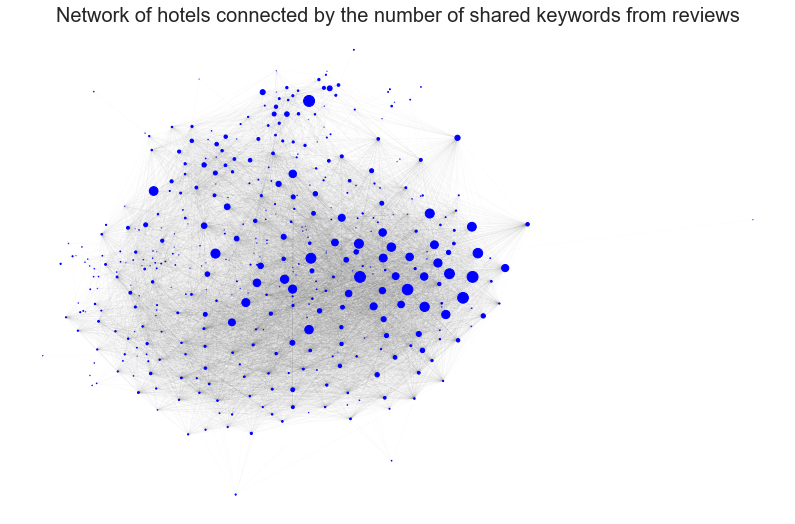

In [7]:
plt.figure(figsize = (14, 9))
plt.tight_layout()
plt.title('Network of hotels connected by the number of shared keywords from reviews',fontsize=20, loc='center')
nx.draw(G, pos = positions, node_size = node_sizes, node_color = 'blue', width = 0.01)

### Interactive plot with Plotly

By hovering over the interactive graph, you will be able to find how many connections each hotel has with its neighbors/competitors. It can be clearly seen that the most popular nodes are also some of the ones with highest degree of connection, meaning that they share a larger number of competitors than most other businesses. 

In [8]:
# Extract latitude of hotel corresponding to each node
lat = list(business_df[business_df.business_id.isin(G.nodes())].latitude)

# Extract longitude of hotel corresponding to each node
lon = list(business_df[business_df.business_id.isin(G.nodes())].longitude)

# Define position of nodes using latitude and longitude
position = dict(zip(G.nodes(), zip(lat, lon)))

# Use review_count (while minimizing it to a reasonable scale for plotting) to indicate the node size
node_size = list(business_df[business_df.business_id.isin(G.nodes())].review_count*0.005)

for n,p in positions.items():
    G.nodes[n]['pos']=p
    
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.01, color='darkred'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Blackbody',
        reversescale=True,
        color=[],
        size=node_size,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_adjacencies = []
node_text = []
node_names = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

for node in G.adjacency():
     node_names.append(nx.get_node_attributes(G, 'business_name')[node[0]])

node_trace.marker.color = node_adjacencies
node_trace.text = list(zip(node_names,node_text))

### create graph 
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                plot_bgcolor='white',
                title='Hotels network',
                titlefont_size=30,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=60),
                annotations=[ dict(
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

### Degree distribution 

To verify whether the assumption that the network follows Barabasi-Albert properties the linear and log-log degree distribution of the network are plotted, as done below.

The network edges are weight-adjusted depending on the number of common review keyworks, with higher thickness/weight meaning higher number of common keywords found.

- The maximum degree in the network is 160

- The minimum degree in the network is 1 

In [9]:
degree_list = [x[1] for x in list(G.degree())]

max_degree = max(degree_list)
min_degree = min(degree_list)

print('The maximum degree in our network is:', max_degree)
print('The minimum degree in our network is:', min_degree)

The maximum degree in our network is: 160
The minimum degree in our network is: 1


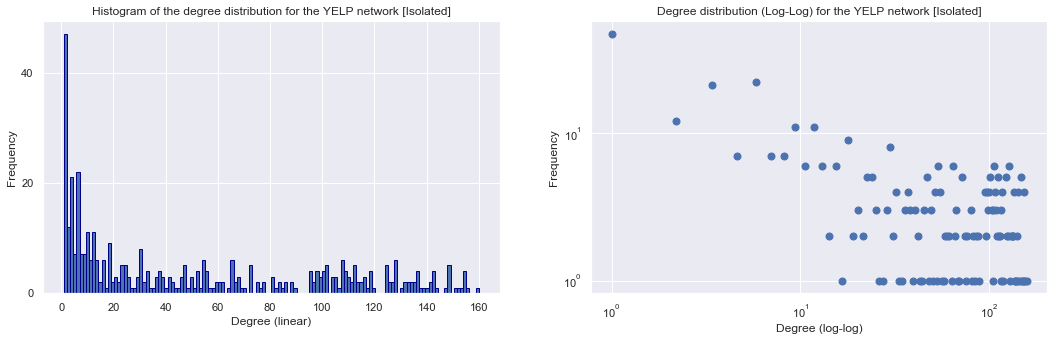

In [10]:
hist, bins = np.histogram(degree_list, bins = len(set(degree_list)))

fig, axs = plt.subplots(1, 2, figsize = (18, 5))

counts = axs[0].hist(degree_list, bins = bins, ec = "darkblue")
axs[0].set_title('Histogram of the degree distribution for the YELP network [Isolated]')
axs[0].set_yticks(ticks = range(0, max(hist) + 1, 20));
axs[0].set_xlabel('Degree (linear)')
axs[0].set_ylabel('Frequency')

axs[1].loglog(bins[:-1], hist, 'bo', markersize = 7)
axs[1].set_title('Degree distribution (Log-Log) for the YELP network [Isolated]')
axs[1].set_xlabel('Degree (log-log)')
axs[1].set_ylabel('Frequency');

## Community detection 

To investigate whether there are any groupings or clusters of hotels which are similar in terms of their special features or experiences (which get mentioned in users' reviews), we have performed community detection. 

For this, we compute and maximize the modularity score of each group of nodes through using the __Louvain__ algorithm, which looks as how much more densely connected the nodes in a community are, compared to how connected the same nodes would be in a random network. The Louvain algorithm is an unsupervised clustering method, and allows finding of the best partition of nodes into communities from a full-scale graph.

**4 communities have been found and visualised via Force Atlas Algorithmn and Plotly (interactive) below.**

In [11]:
import community

# Find the best community partition for the DC universe
partition_hotels = community.best_partition(G, random_state = 3)

print("The Louvain algorithm has found", len(set(partition_hotels.values())), "communities for hotel landscape in Las Vegas.")

The Louvain algorithm has found 4 communities for hotel landscape in Las Vegas.


In [12]:
# For this visualization, let's create a modifiable copy of the DC subgraph
viz_hotels_graph = G.copy()

# Split the nodes by their community number
dict_communities = {}

for community_nr in range(0, max(partition_hotels.values()) + 1):
    dict_communities[community_nr] = [name for name, comm in partition_hotels.items() if comm == community_nr]

# Create instance for FA2
forceatlas2 = FA2(scalingRatio = 100, gravity = 100, outboundAttractionDistribution = True)

positions = forceatlas2.forceatlas2_networkx_layout(viz_hotels_graph, pos = None, iterations = 1000)

character_color_dict = {}
community_color_list = ['#00FA9A', '#0000FF', '#228B22', '#6495ED', '#FF1493', '#FFD700', '#4169E1', '#FF0000', '#7FFF00', '#808080', '#3DFA23', '#ABB351']

for community_nr, character_name_list in dict_communities.items():
    
    # For every node in this community, we assign them a previously-computed color
    for character_name in character_name_list:
        character_color_dict[character_name] = community_color_list[community_nr]
                
        
# The node colors in the DICT are not in the same order as the nodes in the graph, therefore we need to create a separate list to deal with that
node_color_list = []
# At the same time, we will create a list of node sizes by looking directly at the degree of each individual node (within the undirected Comics network)
node_size_list = []

for node in viz_hotels_graph:
    
    # Append the appropriate color to a node
    node_color_list.append(character_color_dict[node])

    # Append the appropriate size to a node
    node_size_list.append(viz_hotels_graph.degree(node) * 0.6)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 198.64it/s]

BarnesHut Approximation  took  0.75  seconds
Repulsion forces  took  3.83  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.17  seconds


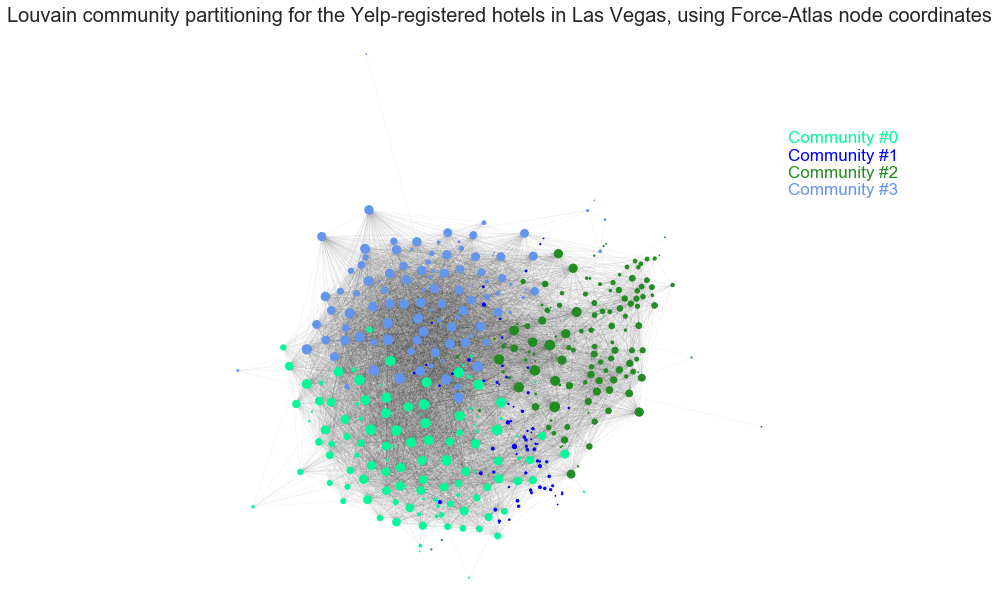

In [13]:
plt.figure(figsize = (8, 8))

nx.draw(viz_hotels_graph, pos = positions, node_size = node_size_list, node_color = node_color_list, width = 0.025)

y = 0.80 # This is the starting Y, for the figure text
# Indicating community colors
for i in dict_communities.keys():
    plt.figtext(1, y, str('Community #' + str(i)), size = 17, color = community_color_list[i])
    y = y - 0.03

plt.title("Louvain community partitioning for the Yelp-registered hotels in Las Vegas, using Force-Atlas node coordinates", fontsize = 20);

The visual representation shows a clear separation of the network plot into the 4 communities, which is a very nice result. It seems that there are 3 large communities of approximatively similar sizes, and one smaller community whose nodes are scattered across the graph due to their interaction with a wide variety of hotels located all across the graph.

In [15]:
# Add position information of edges
edge_trace_community = edge_trace

# Add position information of nodes
node_trace_community = node_trace

# Change color of edges
edge_trace_community['line']['color'] = 'darkred'

# Remove colorbar
node_trace_community['marker']['showscale'] = False

node_group = []
node_names = []

for node in G.adjacency():
    
    # Extract the names of nodes/hotels to show on plot
    node_names.append(nx.get_node_attributes(G, 'business_name')[node[0]])
    
    # Store the texts to indicates which community the node belongs to on the plot
    node_group.append('Community: '+ str([k for k,v in dict_communities.items() if node[0] in v]))
# Assign different colors to the nodes which belong to different communities 
# The color list is the same one used in community partition
node_trace_community.marker.color = node_color_list

# Combine names and explanatory texts of nodes for plotting
node_trace_community.text = list(zip(node_names, node_group))
# Plot interactive graph
fig_network_community = go.Figure(data = [edge_trace_community, node_trace_community],
                                  layout = go.Layout(plot_bgcolor = 'white',
                                  title = 'Communities Network',
                                  titlefont_size = 20,
                                  showlegend = False,
                                  hovermode = 'closest',
                                  margin = dict(b=0, l=0, r=0, t=60),
                                  annotations = [dict(showarrow = False,
                                                      text = 'Interactive visualization of the Yelp communities of hotels in Las Vegas',
                                                      xref = 'paper', 
                                                      yref = 'paper',
                                                      x = 0.005, 
                                                      y = -0.002)],
                                  xaxis = dict(showgrid = False, zeroline = False, showticklabels = False),
                                  yaxis = dict(showgrid = False, zeroline = False, showticklabels = False)))
fig_network_community.show()

The interactive visualization helps easily see that some of the very **popular hotels are residing in Community 3**, and that perhaps might have an important effect as to why they have been grouped together in the same community. 

By hovering over the interactive graph, you will be able able to find which hotels are belonging to what community.

### Community Wordclouds

We will take a look at what words characterize each community. It is relevant to see this, in order to understand if there is a trend for **why certain hotels were grouped together**, and also for understanding what kind of experiences do you normally get from hotels in that community.

We have aggregated all the reviews for each community independently, and calculate TF, IDF and TF-IDF scores upon their aggregated reviews.

In [16]:
# Convert reviews of each community into one text for analysis
community_reviews = reviews(df = business_review_df, mode = 'community', dict_communities = dict_communities)
# Calculate term frequency of each community
community_term_frequency = tf(reviews = community_reviews, tf_method = 'term_frequency')
# Calculate inverse document frequency of each community
community_inverse_document_frequency  =  idf(reviews = community_reviews, term_frequency = community_term_frequency, idf_method = 'idf')
# Calculate TF-IDF score of each community
community_tf_idf = tf_idf(term_frequency = community_term_frequency,  inverse_document_frequency = community_inverse_document_frequency)

# Function for converting the word dictionary into a string
def dict_to_string(word_dict, amplify=True):
    
    total_string = ''
    
    for word in word_dict:
        
        # If the tf-idf scores of words are too small, we times the original score by 1e8 for differentiating them better
        if amplify==True:
            repeat_nr = math.ceil(word_dict[word] * (10**8))
        
        else:
            repeat_nr = math.ceil(word_dict[word])
        
        # Create a string of one term (occuring, in a proportional manner, according to the TF-TR scores)
        string = ''.join([word + ' ' for count in range(repeat_nr)])
        
        # Concatenate the current elements to the total string
        total_string += string
        
    return total_string

In [17]:
text = {}
wordclouds = []
for comm in community_tf_idf.keys():
    text[comm] = dict_to_string(community_tf_idf[comm], False)

In [18]:
def create_wordcloud(frame = fixed(text) , community = [0, 1, 2, 3], maximum = [50,100,300] , atitle = fixed('')):
    if community == 0:
        mk = imageio.imread('./data/club.jpg')
    if community == 1:
        mk = imageio.imread('./data/diamond.png')
    if community == 2:
        mk = imageio.imread('./data/spade.jpg')
    if community == 3:
        mk = imageio.imread('./data/heart.jpg')
   
    wordcloud = WordCloud(max_font_size = 70, 
                                       max_words = maximum, 
                                       background_color = 'white',
                                       collocations = False,
                                       mask = mk).generate(text[community])
    image_colors = ImageColorGenerator(mk)
    
    plt.style.use('seaborn')
    plt.figure(figsize=[15, 15])
    plt.title('community '+str(community), fontsize = 20)
    plt.imshow(wordcloud.recolor(color_func = image_colors), interpolation = 'bilinear')
    plt.axis('off')
@interact   
def create_wordcloud(frame = fixed(text) , community = [0, 1, 2, 3], maximum = [50,100,300] , atitle = fixed('')):
    if community == 0:
        mk = imageio.imread('./data/club.jpg')
    if community == 1:
        mk = imageio.imread('./data/diamond.png')
    if community == 2:
        mk = imageio.imread('./data/spade.jpg')
    if community == 3:
        mk = imageio.imread('./data/heart.jpg')
   
    wordcloud = WordCloud(max_font_size = 70, 
                                       max_words = maximum, 
                                       background_color = 'white',
                                       collocations = False,
                                       mask = mk).generate(text[community])
    image_colors = ImageColorGenerator(mk)
    
    plt.style.use('seaborn')
    plt.figure(figsize=[15, 15])
    plt.title('community '+str(community), fontsize = 20)
    plt.imshow(wordcloud.recolor(color_func = image_colors), interpolation = 'bilinear')
    plt.axis('off')
    

interactive(children=(Dropdown(description='community', options=(0, 1, 2, 3), value=0), Dropdown(description='…

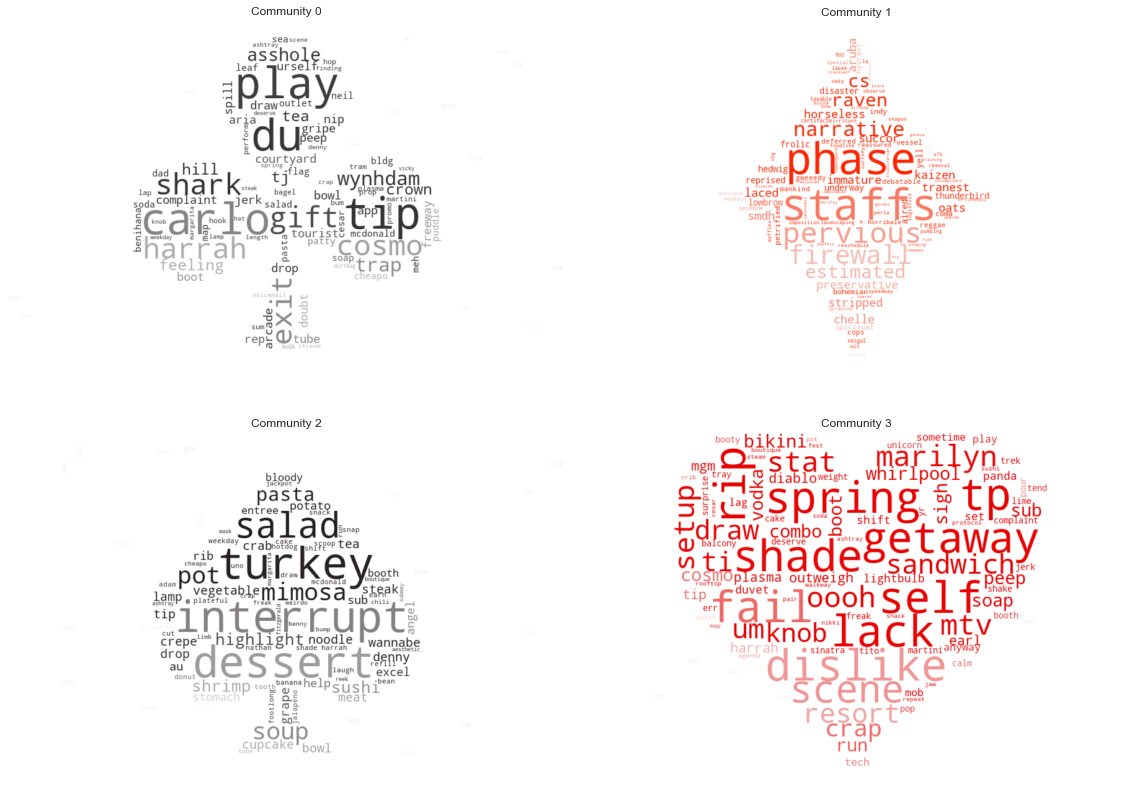

In [19]:
text = {}
wordclouds = []
colors = []
for comm in community_tf_idf.keys():
    text[comm] = dict_to_string(community_tf_idf[comm], False)
    
    # Static wordclouds (as interactive one does not show on the jupyter notebook)
    if comm == 0:
        mk = imageio.imread('./data/club.jpg')
    if comm == 1:
        mk = imageio.imread('./data/diamond.png')
    if comm == 2:
        mk = imageio.imread('./data/spade.jpg')
    if comm == 3:
        mk = imageio.imread('./data/heart.jpg')
   
    wordclouds.append(WordCloud(max_font_size = 70, 
                                                max_words = 100, 
                                                background_color = 'white',
                                                collocations = False,
                                                mask = mk).generate(text[comm]))
    colors.append(ImageColorGenerator(mk))
# Display the generated images
fig, axs = plt.subplots(2, 2,figsize=(16,12))
axs[0, 0].imshow(wordclouds[0].recolor(color_func = colors[0]), interpolation='bilinear')
axs[0, 0].set_title('Community 0')
axs[0, 0].axis('off')

axs[0, 1].imshow(wordclouds[1].recolor(color_func = colors[1]), interpolation='bilinear')
axs[0, 1].set_title('Community 1')
axs[0, 1].axis('off')

axs[1, 0].imshow(wordclouds[2].recolor(color_func = colors[2]), interpolation='bilinear')
axs[1, 0].set_title('Community 2')
axs[1, 0].axis('off')

axs[1, 1].imshow(wordclouds[3].recolor(color_func = colors[3]), interpolation='bilinear')
axs[1, 1].set_title('Community 3')
axs[1, 1].axis('off')

plt.tight_layout(pad = 1)

The community wordplot shows multiple very interesting and relevant findings:

* Community 0 contains many keywords related to casino ('_tip_', '_carlo_', '_shark'_, '_booth_', etc.), as well as words related to the adult night life of Las Vegas.


* Community 1 is the hardest one to pin-point. It seems that a central "theme" of the reviews belonging to hotels in this community is centered about the hotel staff, and words related to security. Later on, we will find that this community is also the one with the lowest sentiment score, which indicates that the comments regarding the staff here are not encouraging ones.


* Community 2 (_which we will later see that it is the happiest community_) is related very strongly to food, desserts and fruits. The hotels grouped in this community seem to have the common specialization in exquisite and delicious culinary adventures.


* Community 3 seems to have most words related to games, alcoholic drinking, as well as swear words, indicating that this community may be strongly involved with bar-hotels and the ones of a more "frivolous" nature.